## Importing the Required Libraries

In [9]:
import splitfolders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import cv2
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
from torchvision import datasets, transforms

import os, shutil, time

device = "cpu"
if torch.cuda.is_available():             # Check if GPU is available
    device = "cuda"
    
print(device)

cuda


In [ ]:
!pip install split-folders

### Splitting the entire data into train, val and test sets

In [13]:
splitfolders.ratio('../input/', output="../output/", seed=1337, ratio=(.8, 0.1,0.1)) 



Copying files: 0 files [00:12, ? files/s]


Copying files: 1 files [00:01,  1.10s/ files]

Copying files: 10 files [00:01, 11.11 files/s]

Copying files: 20 files [00:01, 23.05 files/s]

Copying files: 29 files [00:01, 33.17 files/s]

Copying files: 37 files [00:01, 41.12 files/s]

Copying files: 47 files [00:01, 52.87 files/s]

Copying files: 57 files [00:01, 63.07 files/s]

Copying files: 69 files [00:01, 75.47 files/s]

Copying files: 83 files [00:01, 90.28 files/s]

Copying files: 94 files [00:02, 91.74 files/s]

Copying files: 105 files [00:02, 91.90 files/s]

Copying files: 118 files [00:02, 100.60 files/s]

Copying files: 129 files [00:02, 95.44 files/s] 

Copying files: 142 files [00:02, 101.78 files/s]

Copying files: 153 files [00:02, 100.04 files/s]

Copying files: 164 files [00:02, 98.15 files/s] 

Copying files: 174 files [00:02, 96.50 files/s]

Copying files: 186 files [00:02, 101.35 files/s]

Copying files: 197 files [00:03, 102.26 files/s]

Copying files: 210 files [0

In [24]:
list_files = os.listdir('../output')
list_train_files = os.listdir('../output/train/landscape-pictures/')
list_val_files = os.listdir('../output/val/landscape-pictures/')
list_test_files = os.listdir('../output/test/landscape-pictures/')

print(len(list_train_files))
print(len(list_val_files))
print(len(list_test_files))

3455
431
433


##### Function to load the dataset

In [25]:
class LoadData(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original)
            img_lab = rgb2lab(img_original)
            img_lab = (img_lab + 128) / 255
            img_ab = img_lab[:, :, 1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
            img_original = rgb2gray(img_original)
            img_original = torch.from_numpy(img_original).unsqueeze(0).float()

        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return img_original, img_ab, target

In [31]:
# Training
train_transforms = transforms.Compose([transforms.Resize((224,224))])
train_imagefolder = LoadData('../output/train/', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize((224,224))])
val_imagefolder = LoadData('../output/val/' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

# test
test_transforms = transforms.Compose([transforms.Resize((224,224))])
test_imagefolder = LoadData('../output/test/' , test_transforms)
test_loader = torch.utils.data.DataLoader(test_imagefolder, batch_size=64, shuffle=False)

In [32]:
for i, (input_gray, input_ab, target) in enumerate(val_loader):
  print(input_gray.shape)
  print()
  print(input_ab.shape)
  print()
  print(target.shape)
  break

torch.Size([64, 1, 224, 224])

torch.Size([64, 2, 224, 224])

torch.Size([64])


In [87]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])


    ## Second half: Upsampling
    self.decoder = nn.Sequential(     
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2),
      
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)


    # Upsample to get colors
    output = self.decoder(midlevel_features)
    return output

In [88]:
model = Model()
model = model.to(device)

### Using MSE loss function and Adam Optimizer

In [89]:
loss_func = nn.MSELoss()
loss_func.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay =0.0)

In [90]:
## Writing the training function

def train_epoch(model, data_loader, loss_func, optimizer, device):
    model= model.train()
    losses = []
    total_batches = len(data_loader)
    i=1
    
    start = time.time()
    
    for i, (input_gray, input_ab, target) in enumerate(data_loader):
        input_gray = input_gray.to(device)
        input_ab = input_ab.to(device)
        target = target.to(device)
        
        # Run forward pass
        output_ab = model(input_gray) 
        loss = loss_func(output_ab, input_ab) 
        losses.append(loss.item())
        
        
        if ((i+1)%10) == 0:
            print("Batch {}/{} Train Loss {:.4f} ".format(i+1, total_batches, loss.item()))
        i += 1
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        optimizer.zero_grad()
    
    end =  time.time()
    epoch_time = end-start
    return np.mean(losses),epoch_time

In [91]:
## Evaluation function

def eval_model(model, data_loader, loss_func,device):
    model = model.eval()
    
    losses = []
    eval_predictions = []
    
    already_saved_images = False
    
    with torch.no_grad():
        for i, (input_gray, input_ab, target) in enumerate(data_loader):
            input_gray = input_gray.to(device) 
            input_ab = input_ab.to(device)
            target = target.to(device)
            
            output_ab = model(input_gray) 
            loss = loss_func(output_ab, input_ab)
            losses.append(loss.item())
            
            eval_predictions.append((output_ab,input_ab))
            
    return np.mean(losses),eval_predictions

In [ ]:
# Make folders and set parameters
os.makedirs('checkpoints')
best_losses = 1e10


In [93]:
epochs = 30

In [94]:
## Running both loops
history = {"train_loss":[], "val_loss":[]}
least_loss = 10000

for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch + 1, epochs))
    print("-"*100)
    train_loss, epoch_time = train_epoch(model, train_loader, loss_func, optimizer, device)
    print("Train Loss {:.4f}  Training Epoch Time {:.3f}s".format(train_loss,epoch_time))
    print()
    
    val_loss,val_predictions = eval_model(model, val_loader, loss_func, device)
    print("Validation Loss {:.4f} ".format(val_loss))
    print()
    
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    
    if val_loss < least_loss:
        torch.save(model.state_dict(), "best_model_state.bin")
        least_loss = val_loss

Epoch 1/30
----------------------------------------------------------------------------------------------------
Batch 10/54 Train Loss 0.0355 
Batch 20/54 Train Loss 0.0142 
Batch 30/54 Train Loss 0.0084 
Batch 40/54 Train Loss 0.0060 
Batch 50/54 Train Loss 0.0056 
Train Loss 0.0631  Training Epoch Time 123.305s

Validation Loss 0.0053 

Epoch 2/30
----------------------------------------------------------------------------------------------------
Batch 10/54 Train Loss 0.0055 
Batch 20/54 Train Loss 0.0049 
Batch 30/54 Train Loss 0.0054 
Batch 40/54 Train Loss 0.0080 
Batch 50/54 Train Loss 0.0047 
Train Loss 0.0057  Training Epoch Time 122.529s

Validation Loss 0.0047 

Epoch 3/30
----------------------------------------------------------------------------------------------------
Batch 10/54 Train Loss 0.0043 
Batch 20/54 Train Loss 0.0040 
Batch 30/54 Train Loss 0.0077 
Batch 40/54 Train Loss 0.0047 
Batch 50/54 Train Loss 0.0037 
Train Loss 0.0049  Training Epoch Time 123.258s

Va

In [95]:
print("\n Final Test Loss :\n")
test_loss,test_predictions = eval_model(model, test_loader, loss_func, device)
print(test_loss)


 Final Test Loss :

0.008228832988866739


Text(0, 0.5, 'Loss')

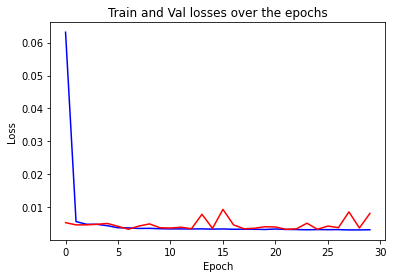

In [96]:
plt.plot(history["train_loss"], 'b')
plt.plot(history["val_loss"], 'r')
plt.title('Train and Val losses over the epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [97]:
# To store the outputs
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)

In [98]:
def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
    plt.clf() # clear matplotlib 
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128  
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    if save_path is not None and save_name is not None: 
        plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
        plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [99]:
# test_predictions[i][0] is our prediction and test_predictions[i][1] is the actual value
test_predictions[0][0].shape, test_predictions[0][1].shape, len(test_predictions)

(torch.Size([64, 2, 224, 224]), torch.Size([64, 2, 224, 224]), 7)

In [100]:
save_path = {'grayscale': './outputs/gray/', 'colorized': './outputs/color/'}

In [108]:
#here we will be comparing the first image of first 10 batches of test_loader
for i, (input_gray, input_ab, target) in enumerate(test_loader):
    save_name = 'img-{}-batch-{}.jpg'.format(1, i)
    to_rgb(input_gray[1].cpu(), ab_input= test_predictions[0][0][0].detach().cpu(), save_path=save_path, save_name=save_name)
    if (i==10):
        break

<Figure size 432x288 with 0 Axes>

In [109]:
color_images = os.listdir('./outputs/color')
grayscale_images = os.listdir('./outputs/gray')
image_tuples = list(zip(color_images, grayscale_images))

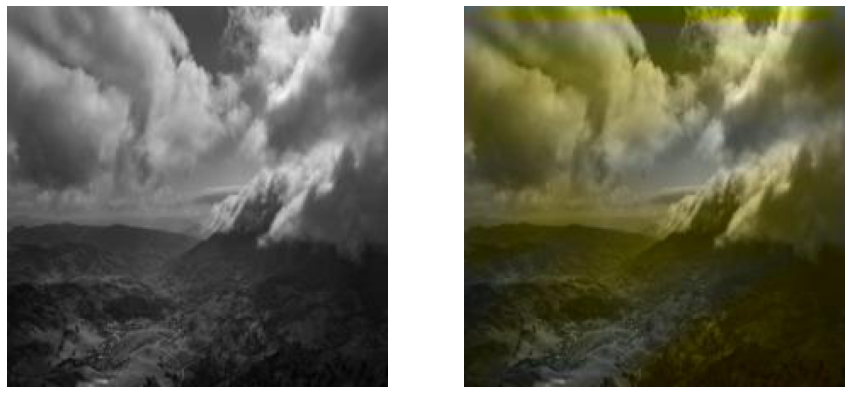

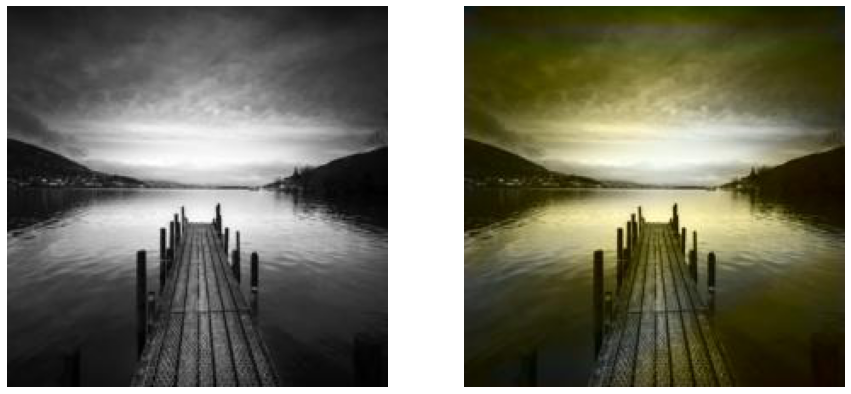

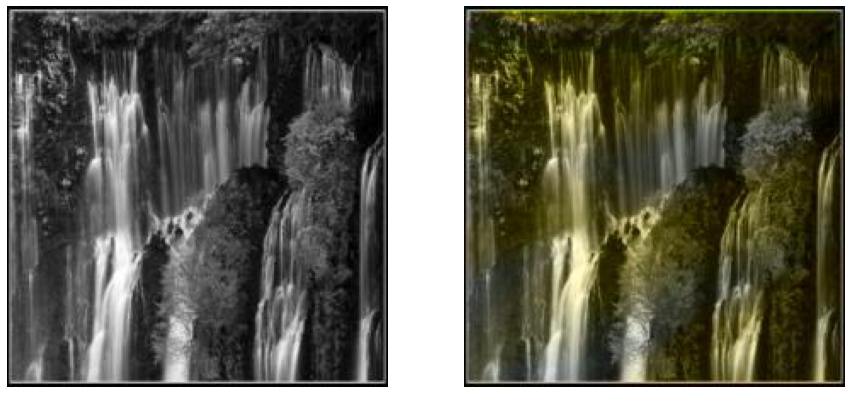

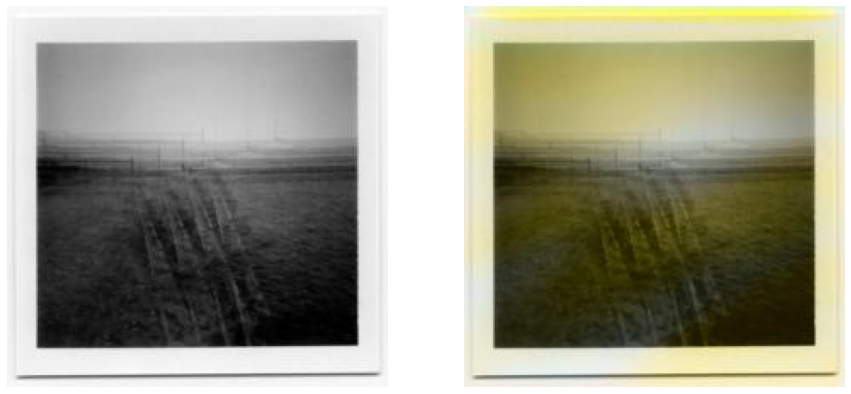

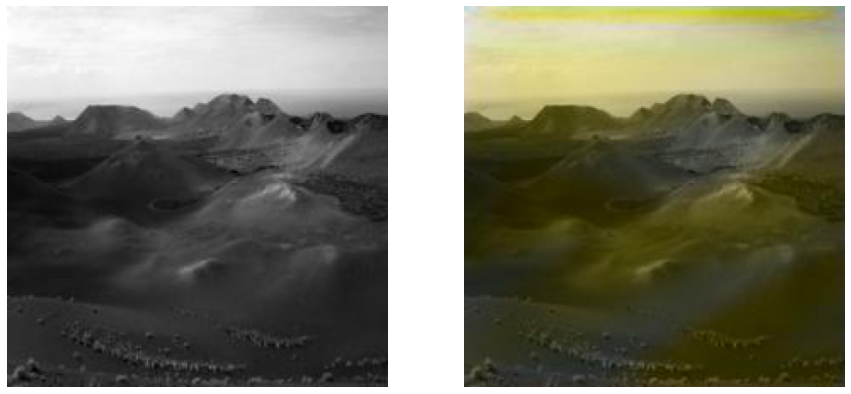

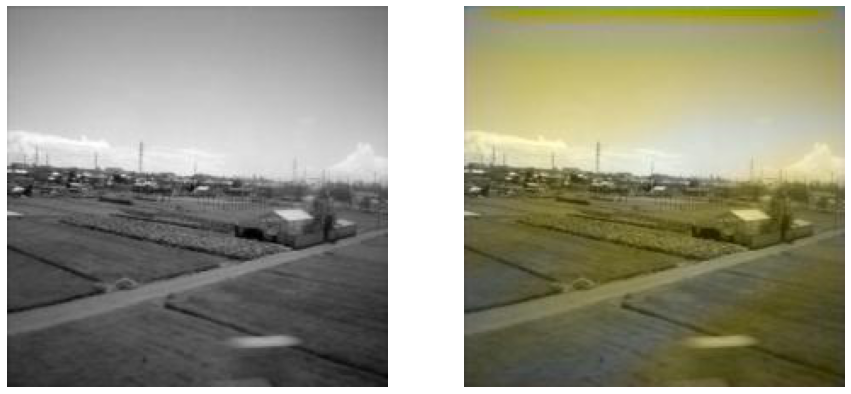

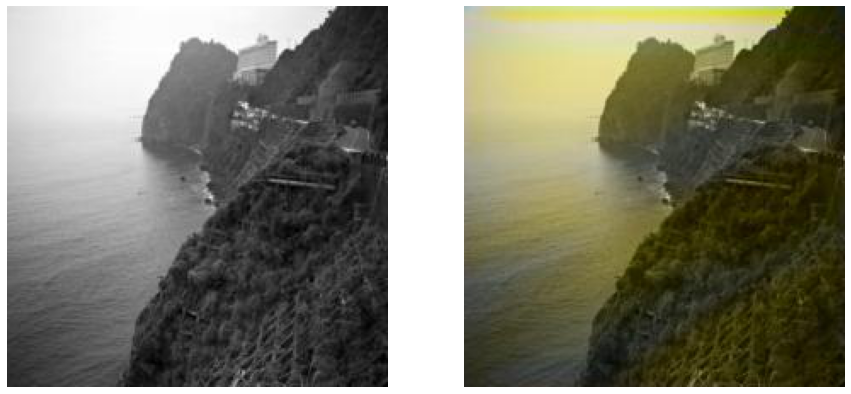

In [110]:
# Show images
for c, g in image_tuples:
    color = mpimg.imread('./outputs/color/'+c)
    gray  = mpimg.imread('./outputs/gray/'+g)
    f, axarr = plt.subplots(1, 2)
    f.set_size_inches(15, 15)
    axarr[0].imshow(gray, cmap='gray')
    axarr[1].imshow(color)
    axarr[0].axis('off'), axarr[1].axis('off')
    plt.show()

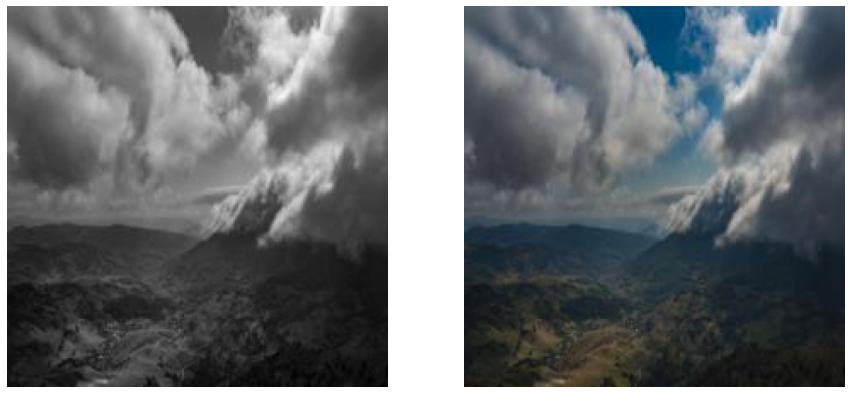

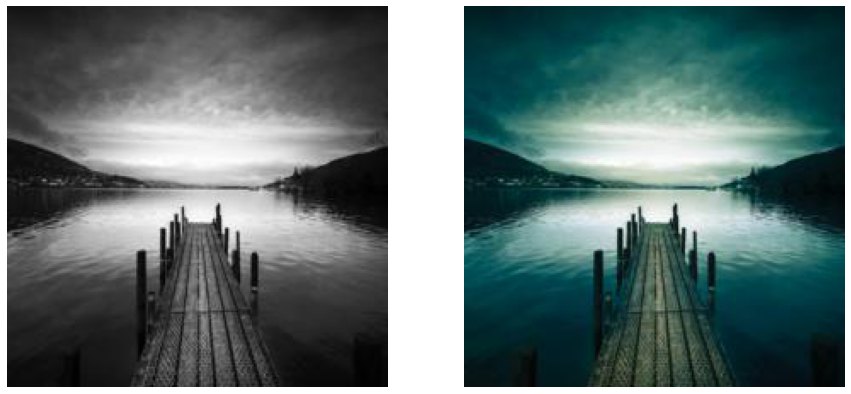

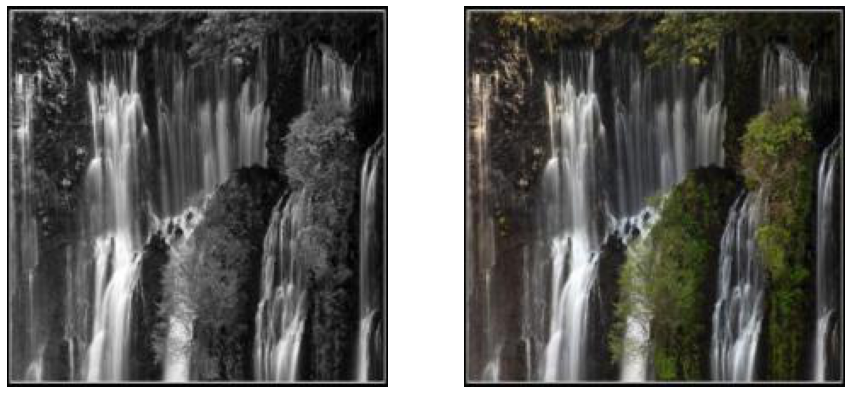

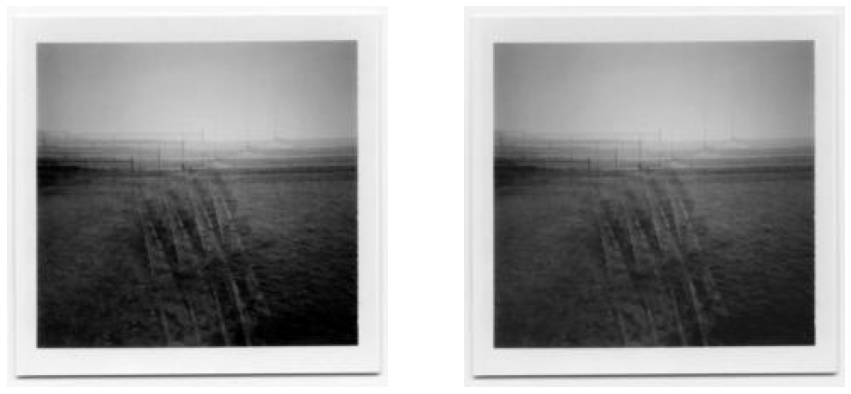

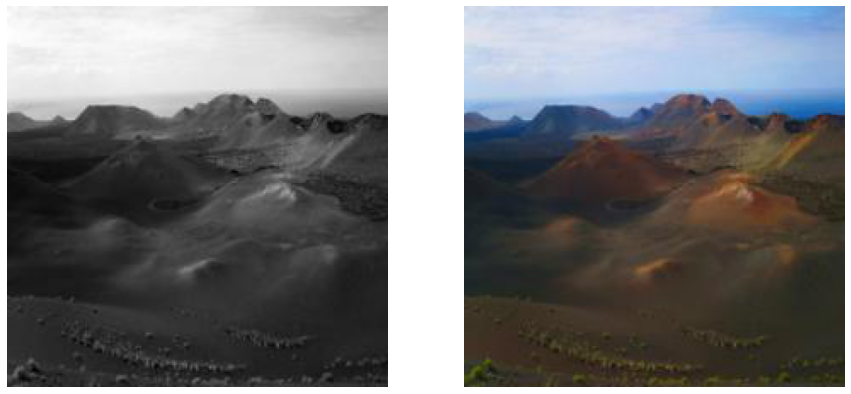

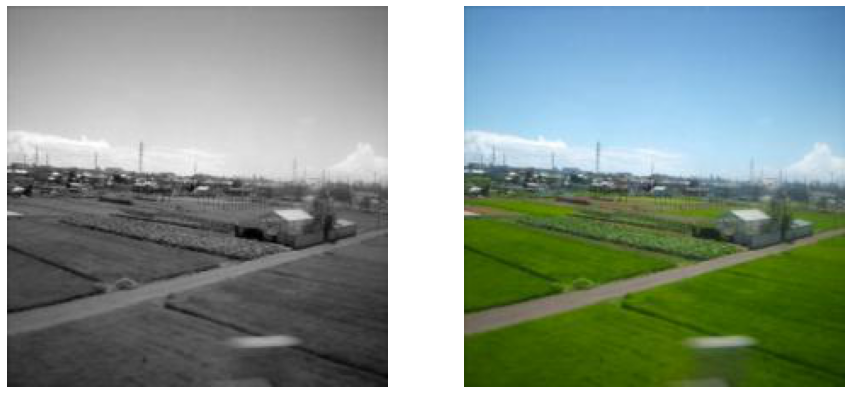

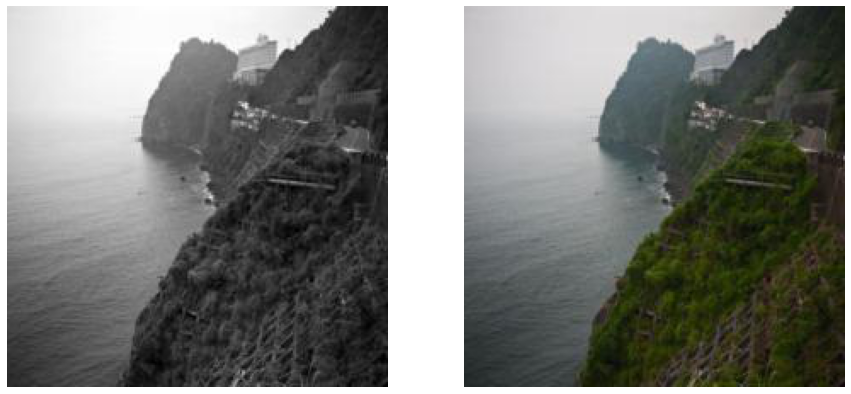

In [107]:
# Show images
for c, g in image_tuples:
    color = mpimg.imread('./outputs/color/'+c)
    gray  = mpimg.imread('./outputs/gray/'+g)
    f, axarr = plt.subplots(1, 2)
    f.set_size_inches(15, 15)
    axarr[0].imshow(gray, cmap='gray')
    axarr[1].imshow(color)
    axarr[0].axis('off'), axarr[1].axis('off')
    plt.show()